In [563]:
import matplotlib.pyplot as plt
import numpy as np 
from scipy.io import loadmat
import pandas as pd
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

In [564]:
#load data chunks and convert to numpy
def load_data_chunks():
    raw_face = np.array(loadmat('./data/data.mat')['face'])
    raw_pose = np.array(loadmat('./data/pose.mat')['pose'])
    raw_illum = np.array(loadmat('./data/illumination.mat')['illum'])
    return raw_face, (raw_pose, raw_illum)
raw_face, raw_pose = load_data_chunks()

In [565]:
# creates face dataset and returns a tuple of 
def make_face_dataset(raw_face, augmented=False):
    neutral= raw_face[:,:,::3]
    smile = raw_face[:,:,1::3]
    variation = raw_face[:,:,2::3]
    if augmented == True:
        face_data = np.dstack((neutral, variation, smile))
        face_data = np.array(np.dsplit(face_data,face_data.shape[-1])).reshape((600,24,21))
        face_data = face_data/255
        face_data = data2.reshape((600,24*21))
        face_labels = np.array([400 * [0] + 200 * [1]])
        return face_data, face_labels
    else:
        face_data = np.dstack((neutral, smile))
        face_data = np.array(np.dsplit(face_data,face_data.shape[-1])).reshape((400,24,21))
        face_data = face_data/255
        face_data = face_data.reshape((400,24*21))
        face_labels = np.array([200 * [0] + 200 * [1]])
        return face_data, face_labels
        

In [574]:
def make_pose_dataset(raw_pose, num_subjects, augmented=False):
    pose_dataset = []
    pose_labels = []
    if augmented == False:
        for subject in range(num_subjects):
            for pose in range(13):
                pose_dataset.append(raw_pose[0][:,:,pose,subject].reshape((48*40)))
                pose_labels.append(subject)
    else:
        for subject in range(num_subjects):
            for pose in range(13):
                pose_dataset.append(raw_pose[0][:,:,pose,subject].reshape((48*40)))
                pose_labels.append(subject)
        for subject in range(num_subjects):
            for pose in range(21):
                img = raw_pose[1][:,pose,subject].reshape((40,48))
                img = np.flip(np.rot90(img)).reshape((48*40))
                pose_dataset.append(img)
                pose_labels.append(subject)
                
    pose_dataset = np.array(pose_dataset)
    pose_labels = np.transpose(np.array(pose_labels))
    return pose_dataset, pose_labels

In [567]:
def show_results(model, X_test, y_test, labels_list):
    ypred = model.predict(X_test)
    mat = confusion_matrix(y_test, ypred) 
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                        xticklabels=labels_list,
                        yticklabels=labels_list)
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    print('Accuracy: ', accuracy_score(y_test, ypred))
    print('F1: ', f1_score(y_test, ypred))
    print('Precision: ', precision_score(y_test, ypred))
    print('Recall: ', recall_score(y_test, ypred)) 

In [568]:
face_data, face_labels = make_face_dataset(raw_face, augmented=True)
print(face_data.shape)
print(face_labels.shape)

(600, 504)
(1, 600)


In [570]:
pose_data, pose_labels = make_pose_dataset(raw_pose, num_subjects=10, augmented=True)
print(pose_data.shape)
print(pose_labels.shape)

(340, 1920)
(340,)


In [187]:
#set dataset here
X_train, X_test, y_train, y_test = train_test_split(data2, labels2, test_size=0.3, random_state=42, shuffle='true', stratify=labels2)

In [190]:
#TASK ONE:Bayes PIPELINE
pca = PCA()
gnb = GaussianNB()

pipe = Pipeline(steps=[('pca', pca), ('bayes', gnb)])

param_grid = {
    'pca__n_components': [i for i in range(1,40)]
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
bayes_search = GridSearchCV(pipe, param_grid, scoring='accuracy', n_jobs=-1, cv=cv)
bayes_search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % bayes_search.best_score_)
print(bayes_search.best_params_)

Best parameter (CV score=0.907):
{'pca__n_components': 16}


Accuracy:  0.8777777777777778
F1:  0.8035714285714286
Precision:  0.8653846153846154
Recall:  0.75


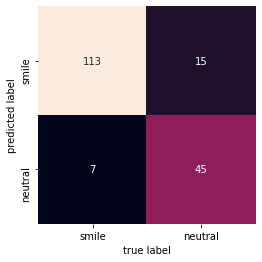

In [191]:
cm(bayes_search, X_test, y_test, ['smile','neutral'])

In [179]:
#TASK ONE:KNN PIPELINE
pca = PCA()
knn = KNeighborsClassifier()

pipe = Pipeline(steps=[('pca', pca), ('knn', knn)])

param_grid = {
    'pca__n_components': [i for i in range(1,31)],
    'knn__n_neighbors' : [i for i in range(1,11)],  
    'knn__metric' : ['euclidean','manhattan','chebyshev','minkowski','wminkowski','seuclidean','mahalanobis'],
    'knn__weights' : ['uniform','distance'],
    
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
knn_search = GridSearchCV(pipe, param_grid, scoring='accuracy', cv=cv, n_jobs=-1)
knn_search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % knn_search.best_score_)
print(knn_search.best_params_)

Best parameter (CV score=0.897):
{'knn__metric': 'manhattan', 'knn__n_neighbors': 9, 'knn__weights': 'uniform', 'pca__n_components': 7}


Accuracy:  0.9040404040404041
F1:  0.8480000000000001
Precision:  0.8983050847457628
Recall:  0.803030303030303


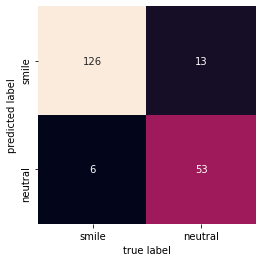

In [180]:
cm(knn_search, X_test, y_test, ['smile','neutral'])

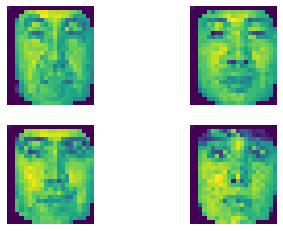

In [632]:
# plt.figure((20,20))
for i in range(4):
    # define subplot
    plt.subplot(2, 2, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(X[i].reshape((24,21)))

In [571]:
#set dataset here
X_train, X_test, y_train, y_test = train_test_split(pose_data, pose_labels, test_size=0.3, random_state=42, shuffle='true', stratify=pose_labels)
print(X_train.shape)
print(X_test.shape)

(238, 1920)
(102, 1920)


In [572]:
#TASK TWO Bayes
pca = PCA()
gnb = GaussianNB()

pipe = Pipeline(steps=[('pca', pca), ('bayes', gnb)])

param_grid = {
    'pca__n_components': [i for i in range(1,40)]
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
bayes_search = GridSearchCV(pipe, param_grid, scoring='accuracy', n_jobs=-1, cv=5)
bayes_search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % bayes_search.best_score_)
print(bayes_search.best_params_)

Best parameter (CV score=0.861):
{'pca__n_components': 39}


In [573]:
#TASK ONE:KNN PIPELINE
pca = PCA()
knn = KNeighborsClassifier()

pipe = Pipeline(steps=[('pca', pca), ('knn', knn)])

param_grid = {
    'pca__n_components': [i for i in range(1,31)],
    'knn__n_neighbors' : [i for i in range(1,11)],  
    'knn__metric' : ['euclidean','manhattan','chebyshev','minkowski','wminkowski','seuclidean','mahalanobis'],
    'knn__weights' : ['uniform','distance'],
    
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
knn_search = GridSearchCV(pipe, param_grid, scoring='accuracy', cv=cv, n_jobs=-1)
knn_search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % knn_search.best_score_)
print(knn_search.best_params_)

Best parameter (CV score=0.843):
{'knn__metric': 'manhattan', 'knn__n_neighbors': 10, 'knn__weights': 'distance', 'pca__n_components': 30}
